# Races Dataset Understanding

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from sklearn.impute import KNNImputer
import random
import math
import seaborn as sb
import matplotlib.pyplot as plt
from unidecode import unidecode

In [3]:
cyclists = pd.read_csv("../data/cyclists.csv")

In [4]:
dataset = pd.read_csv("../data/races.csv")
dataset.head(n=5)

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
0,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,0,sean-kelly,22.0,True,False,False,vini-ricordi-pinarello-sidermec-1986,0.0
1,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,1,gerrie-knetemann,27.0,True,False,False,norway-1987,0.0
2,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,2,rene-bittinger,24.0,True,False,False,NaN,0.0
3,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,3,joseph-bruyere,30.0,True,False,False,navigare-blue-storm-1993,0.0
4,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,4,sven-ake-nilsson,27.0,True,False,False,spain-1991,0.0


## Syntactic and Semantic accuracies analysis

In questa sezione verifichiamo informazioni generiche sui nostri dati. Abbiamo studiato il tipo degli attributi, verificato come questi tipi possano essere cambiati qualora non sinao idonei al dominio degli attributi e abbiamo verificato che i valori non NaN presenti nel dataset risultino all'interno dei rispettivi domini

In [5]:
dataset.info()
# birth year, heigth -> float to int

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589865 entries, 0 to 589864
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   _url                 589865 non-null  object 
 1   name                 589865 non-null  object 
 2   points               589388 non-null  float64
 3   uci_points           251086 non-null  float64
 4   length               589865 non-null  float64
 5   climb_total          442820 non-null  float64
 6   profile              441671 non-null  float64
 7   startlist_quality    589865 non-null  int64  
 8   average_temperature  29933 non-null   float64
 9   date                 589865 non-null  object 
 10  position             589865 non-null  int64  
 11  cyclist              589865 non-null  object 
 12  cyclist_age          589752 non-null  float64
 13  is_tarmac            589865 non-null  bool   
 14  is_cobbled           589865 non-null  bool   
 15  is_gravel        

### Analisi Preliminare

Possiamo osservare che nell'attributo "average_temperature" sono assenti circa il 95% dei valori. La nostra assunzione è quindi che sia impossibile sfruttare questo valore in modo corrertto o correggerlo con una imputazione e pertanto preferiamo rimuoverlo sin da subito per diminuire la dimensionalità del dataset.

Con la stessa analisi appena citata abbiamo rilevato che anche la percentuale di valori mancanti nell'attributo "uci_points" è particolarmente elevata (circa 57%), tuttavia dalle nostre ricerche esterne al dataset, questa categoria di punteggi è stata inventata dopo gli anni 2000, pertanto la mancanza di questi valori potrebbe essere attribuita proprio alla presenza di record risalenti a periodi precedenti alla loro messa in atto. Abbiamo quindi deciso di tenere questi valori nonostante siano assenti nella maggior parte dei record per effettuare analisi mirate

In [6]:
percent_missing = dataset.isnull().sum() * 100 / len(dataset) # compute the percentage of missing values
missing_value_df = pd.DataFrame({'column_name': dataset.columns,
                                 'percent_missing': percent_missing})

missing_value_df['percent_missing']

_url                    0.000000
name                    0.000000
points                  0.080866
uci_points             57.433311
length                  0.000000
climb_total            24.928585
profile                25.123376
startlist_quality       0.000000
average_temperature    94.925449
date                    0.000000
position                0.000000
cyclist                 0.000000
cyclist_age             0.019157
is_tarmac               0.000000
is_cobbled              0.000000
is_gravel               0.000000
cyclist_team           26.982615
delta                   0.000000
Name: percent_missing, dtype: float64

In [7]:
dataset = dataset.drop(columns=['average_temperature'])

In [8]:
dataset.describe()

,points,uci_points,length,climb_total,profile,startlist_quality,position,cyclist_age,delta
count,589388.000000,251086.000000,589865.000000,442820.000000,441671.000000,589865.000000,589865.000000,589752.000000,589865.000000
mean,89.221635,74.601547,166776.180584,2330.469215,2.611611,1101.161178,74.219491,28.486208,418.292794
std,54.435330,100.947962,64545.605664,1375.710722,1.491741,380.586928,48.404023,3.855631,842.961596
min,18.000000,6.000000,1000.000000,2.000000,1.000000,115.000000,0.000000,13.000000,-6906.000000
25%,50.000000,16.000000,152500.000000,1309.000000,1.000000,844.000000,32.000000,26.000000,10.000000
50%,80.000000,60.000000,178200.000000,2255.000000,2.000000,988.000000,70.000000,28.000000,156.000000
75%,100.000000,100.000000,203500.000000,3273.000000,4.000000,1309.000000,112.000000,31.000000,624.000000
max,350.000000,800.000000,338000.000000,6974.000000,5.000000,2047.000000,209.000000,56.000000,61547.000000


### Name Attribute

Assicuratici dell'assenza di valori NaN, analizzando i nomi dei percorsi nel dataset è emerso che riferendosi alla stessa gara fossero registrati nomi diversi. Dopo aver effettuato delle ricerche online (citazione) per ricavarne i nomi ufficiali abbiamo sostituito tutte le occorrenze varianti con i nomi canonici. 

Notando la dicitura "ME" in alcuni nomi abbiamo effettuato altre ricerche specifiche, scoprendo che questa terminologia si riferisca a "Men Elite" che potrebbe quindi distinguere due classi diverse per la stessa gara. Abbiamo per questo mantenuto una distinzione tra i percorsi denominati ME e gli altri. Per comodità abbiamo inserito nel dataset una colonna apposita che non distingue tra ME e standard.

In [9]:
dataset[dataset['name'].notnull()].groupby(by='name', observed=True)['name'].value_counts()

name
Amstel Gold Race                       4349
Clasica Ciclista San Sebastian         3884
Clásica Ciclista San Sebastian           84
Clásica Ciclista San Sebastián          236
Clásica San Sebastián                    52
                                      ...  
Vuelta Ciclista al País Vasco          6529
Vuelta a España                       89222
Vuelta al País Vasco                   7206
World Championships - Road Race        1611
World Championships ME - Road Race     2306
Name: count, Length: 61, dtype: int64

In [10]:
len(dataset['name'].unique())

61

In [11]:
dataset['name'] = dataset['name'].apply(unidecode)
dataset['name'] = dataset['name'].replace(to_replace={'Clasica Ciclista San Sebastian':'Clasica San Sebastian',
                                                      'Donostia San Sebastian Klasikoa':'Clasica San Sebastian',
                                                         'Criterium du Dauphine Libere':'Criterium du Dauphine',
                                                         'Gran Camino':'O Gran Camino',
                                                         'La Vuelta ciclista a Espana':'Vuelta a Espana',
                                                         'Dwars door Belgie / A travers la Belgique':'Dwars door Vlaanderen',
                                                         'Dwars door Vlaanderen - A travers la Flandre ME':'Dwars door Vlaanderen ME',
                                                         'Dwars door Vlaanderen / A travers la Flandre':'Dwars door Vlaanderen',
                                                         'Dwars door Vlaanderen / A travers la Flandre ME':'Dwars door Vlaanderen ME',
                                                         'E3 BinckBank Classic':'E3 Saxo Bank Classic',
                                                         'E3 Harelbeke':'E3 Saxo Bank Classic',
                                                         'E3 Prijs Vlaanderen':'E3 Saxo Bank Classic',
                                                         'E3 Prijs Vlaanderen - Harelbeke':'E3 Saxo Bank Classic',
                                                         'E3 Saxo Classic':'E3 Saxo Bank Classic',
                                                         'E3-Prijs Harelbeke':'E3 Saxo Bank Classic',
                                                         'Record Bank E3 Harelbeke':'E3 Saxo Bank Classic',
                                                         'Giro di Lombardia':'Il Lombardia',
                                                         'Liege - Bastogne - Liege':'Liege-Bastogne-Liege',
                                                         'Monte Paschi Eroica':'Strade Bianche',
                                                         'Montepaschi Strade Bianche - Eroica Toscana':'Strade Bianche',
                                                         'Omloop Het Volk':'Omloop Nieuwsblad',
                                                         'Omloop Het Nieuwsblad ME':'Omloop Nieuwsblad ME',
                                                         'Omloop Het Volk ME':'Omloop Nieuwsblad ME',
                                                         'Paris - Roubaix':'Paris-Roubaix',
                                                         'Ronde van Vlaanderen - Tour des Flandres ME':'Ronde van Vlaanderen ME',
                                                         'Ronde van Vlaanderen / Tour des Flandres':'Ronde van Vlaanderen',
                                                         'Ronde van Vlaanderen / Tour des Flandres ME':'Ronde van Vlaanderen ME',
                                                         'Volta a Catalunya':'Volta Ciclista a Catalunya',
                                                         'Vuelta Ciclista al Pais Vasco':'Vuelta al Pais Vasco',
                                                         })

In [12]:
len(dataset['name'].unique())

32

In [13]:
# Aggiungiamo una colonna 'general_name' per identificare il nome ufficiale della gara 
# senza distinzioni tra ME o meno

dataset['general_name'] = dataset['name'].apply(lambda x: x.split('ME')[0].strip())

### Length Attribute

Abbiamo notato che la lunghezza dei percorsi delle gare sia solitamente riconducibile ad un intero, le poche eccezioni sembrano contenere soltato una trascurabilissima quanità di rumore decimale che abbiamo deciso quindi di rimuovere

In [14]:
# For each record, check if 'length' has .0 at the end. If not prints the value
non_null_values = dataset.dropna(subset=['length'])

non_castable_values = non_null_values[~non_null_values['length'].astype(str).str.endswith('.0')]
non_castable_values = non_castable_values.head(5)

for index, row in non_castable_values.iterrows():
    print(row['_url'], row['length'])

tour-de-suisse/1992/stage-4 32200.000000000004
tour-de-suisse/1992/stage-4 32200.000000000004
tour-de-suisse/1992/stage-4 32200.000000000004
tour-de-suisse/1992/stage-4 32200.000000000004
tour-de-suisse/1992/stage-4 32200.000000000004


### Climb_total Attribute

Il valore climb_total è registrato nel dataset come float ma non presenta cifre decimali. Pertanto senza ulteriori analisi abbiamo deciso di cambiarne il tipo in intero

In [15]:
# For each record, check if 'climb_total' has .0 at the end.

non_null_values = dataset['climb_total'].dropna()
non_castable_values = non_null_values[~non_null_values.astype(str).str.endswith('.0')]

if non_castable_values.empty:
    print("All values are castable to integer")

All values are castable to integer


In [16]:
# climb_total è logicamente un intero
dataset['climb_total'] = dataset[dataset['climb_total'].notnull()]['climb_total'].astype(int)

### Profile Attribute

L'attributo profile è chiaramente categorico. L'unica discrepanza con l'overview dei dati fornitaci con la consegna del progetto è la presenza di un valore in più (da 4 a 5 categorie).
In questa fase tuttavia non riteniamo questa discrepanza essere nociva quanto semplicemente un'occasione per esaminare i profili dei percorsi con una grana più fine

In [17]:
len(dataset[dataset['profile'].notnull()]['profile'].unique())

5

In [18]:
# 'profile' is clearly a categorical attribute, so we change its type
dataset['profile'] = dataset['profile'].astype('category')

### Date Attribute

Poiché l'informazione dell'attributo "date" conteneva dettagli temporali in formato orario, e poiché questi costituiscono più che altro una fonte di rumore per le nostre analisi, abbiamo deciso di rimuovere questa specificità mantenendo un formato "anno-mese-giorno".

Approfittando di questa nuova formattazione abbiamo controllato il primo anno in cui i punteggi "UCI" appaiono nel nostro dataset che confermano la nostra teoria iniziale sull'introduzione di questa valutazione come postumo agli anni 2000

In [19]:
dataset['date'] = dataset['date'].str.split(' ').str[0]
dataset['date'] = pd.to_datetime(dataset['date'], format='%Y-%m-%d')

### Points Attribute

Abbiamo rilevato che l'attributo "points" non si riferisce (al contrario di quanto intuibile) ai punteggi guadagnati da un dato ciclista in un dato stage di una data gara, ma bensì a un valore predefinito a seconda di gara, stage e anno in cui si è tenuta la competizione

In [58]:
dataset.groupby('name')['points'].nunique()

name
Amstel Gold Race                      1
Clasica San Sebastian                 2
Criterium du Dauphine                 3
Dwars door Vlaanderen                 2
Dwars door Vlaanderen ME              1
E3 Saxo Bank Classic                  2
Giro d'Italia                         3
Grand Prix Cycliste de Montreal       1
Grand Prix Cycliste de Quebec         1
Il Lombardia                          1
Itzulia Basque Country                1
La Fleche Wallonne                    1
Liege-Bastogne-Liege                  1
Milano-Sanremo                        1
O Gran Camino                         1
Omloop Nieuwsblad                     1
Omloop Nieuwsblad ME                  2
Paris - Nice                          3
Paris-Roubaix                         1
Ronde van Vlaanderen                  1
Ronde van Vlaanderen ME               1
Strade Bianche                        3
Tirreno-Adriatico                     2
Tour de France                        3
Tour de Romandie                   

In [70]:
tmp_df = tmp_df = pd.DataFrame({
    '_url': dataset['_url'],
    'name': dataset['name'],
    'year': dataset['date'].dt.year,
    'points': dataset['points'],
    'uci_points': dataset['uci_points']
})

n_points = tmp_df.groupby(['year', 'name'])['points'].nunique()
n_points = n_points[n_points > 1]
n_points

year  name                 
1999  Tour de France           2
2000  Tour de France           2
2001  Tour de France           2
2002  Giro d'Italia            2
      Tour de France           2
2003  Tour de France           2
2004  Tour de France           2
      Vuelta a Espana          2
2005  Criterium du Dauphine    2
      Giro d'Italia            2
      Tour de France           3
      Tour de Suisse           2
      Vuelta a Espana          2
2006  Criterium du Dauphine    3
      Giro d'Italia            2
      Tirreno-Adriatico        2
      Tour de Suisse           2
2008  Paris - Nice             2
      Tirreno-Adriatico        2
2009  Giro d'Italia            3
Name: points, dtype: int64

L'analisi qui sopra rivela che conoscere l'anno in cui si è svolta la competizione e il nome della competizione non ci permette di determinare un univoco punteggio per tutti i record riconducibili a quella coppia competizione-anno. Nell'analisi successiva proviamo allora a distinguere per "_url", attributo che dovrebbe raccogliere informazioni sul nome e anno della competizione, distinugendo però per i vari stage della stessa

In [71]:
n_points = tmp_df.groupby(['name', '_url'])['points'].nunique()
n_points = n_points[n_points > 1]
n_points

Series([], Name: points, dtype: int64)

Abbiamo confermato l'ipotesi iniziale per cui ogni stage di ogni gara ha associato un univoco punteggio nel nostro dataset. Questa peculiarità conferma che il punteggio non è un valore relativo alla posizione di arrivo nella competizione nè un valore che potremmo associare ai ciclisti in maniera diretta. Potrebbe essere comunque interessante in futuro eseguire delle analisi riguardo a correlazione tra ciclisti e punteggi per poter scoprire relazioni inaspettate (ad esempio potremmo scoprire che le gare più prestigiose che danno più punteggi sono frequentate dai ciclisti più prestigiosi)

### UCI Points Attribute

In [72]:
dataset.groupby('name')['uci_points'].nunique()

name
Amstel Gold Race                      1
Clasica San Sebastian                 1
Criterium du Dauphine                 2
Dwars door Vlaanderen                 1
Dwars door Vlaanderen ME              1
E3 Saxo Bank Classic                  1
Giro d'Italia                         3
Grand Prix Cycliste de Montreal       1
Grand Prix Cycliste de Quebec         2
Il Lombardia                          1
Itzulia Basque Country                1
La Fleche Wallonne                    1
Liege-Bastogne-Liege                  2
Milano-Sanremo                        2
O Gran Camino                         1
Omloop Nieuwsblad                     0
Omloop Nieuwsblad ME                  2
Paris - Nice                          2
Paris-Roubaix                         2
Ronde van Vlaanderen                  0
Ronde van Vlaanderen ME               2
Strade Bianche                        4
Tirreno-Adriatico                     2
Tour de France                        3
Tour de Romandie                   

In [73]:
n_points = tmp_df.groupby(['year', 'name'])['uci_points'].nunique()
n_points = n_points[n_points > 1]
n_points

year  name           
2015  Vuelta a Espana    2
2016  Tour de Suisse     2
Name: uci_points, dtype: int64

In [74]:
n_points = tmp_df.groupby(['name', '_url'])['uci_points'].nunique()
n_points = n_points[n_points > 1]
n_points

Series([], Name: uci_points, dtype: int64)

Anche per l'attributo "uci_points" possiamo confermare quanto detto nel caso precedente. I valori in questo campo dipendono univocamente dalla gara specifica e dallo stage di questa che si sta analizzando

### Position Attribute

Attributo "position" rappresenta la posizione di un ciclista nella classifica di una determinata gara. Questo valore è rappresentato come un intero all'interno del dataset e abbiamo discusso se potesse essere rappresentato come categorico. Notando che per gare diverse però il numero delle posizioni totali e di conseguenza il loro valore relativo nella classifca sono differenti abbiamo preferito tenere questo valore in considerazione esclusivamente come un intero poiché altrimenti avremmo che il valore della stessa categoria avrebbe sfumatore di significato differenti in base alla competizione, fattore che ci è sembrato inopportuno per questa tipologia di dati

### Is_foo Attributes

Gli attributi "is_cobbled", "is_gravel" e "is_tarmac" rappresentano tre condizioni booleane mutualmente esclusive. Riteniamo che fondere questi attributi in un unico attributo di tipo categorico possa ridurre la dimensionalità del nostro dataset senza generare perdite di informazione. Abbiamo quindi deciso di eliminare queste 3 colonne inserendo al loro posto l'attributo "terrain"

In [20]:
at_least2_true = dataset[['is_cobbled', 'is_gravel', 'is_tarmac']].sum(axis=1) >= 2
all(at_least2_true == False)

True

In [21]:
dataset['terrain'] = dataset[['is_cobbled', 'is_gravel', 'is_tarmac']].idxmax(axis=1)
dataset = dataset.drop(columns=['is_cobbled', 'is_gravel', 'is_tarmac'])
dataset['terrain'] = dataset['terrain'].replace(to_replace={'is_cobbled':'0',
                                                            'is_gravel':'1',
                                                            'is_tarmac':'2'})
dataset['terrain'] = dataset['terrain'].astype(int)

### Cyclists and Cyclists Age Attributes

Poiché questi dati sono streattamente correlati con quelli presenti nel dataset "cyclists.csv" riteniamo opportuno poter fare analisi incrociate su gli attributi di entrambe le sorgenti, per questo iniziamo questa sezione con la join dei due dataset. Per comodità abbiamo rinominato alcuni attributi elencati di seguito:
* race_url: url della competizione (_url in races.csv);
* race_name: nome convenzionale della competizione (name in races.csv);
* cyclist_url: url del ciclista (_url in cyclists.csv e cyclist in races.csv);
* cyclist_name: nome del ciclista (name in cyclists.csv).

In [22]:
dataset['cyclist_age'] = dataset[dataset['cyclist_age'].notnull()]['cyclist_age'].astype(int)

join_df = dataset.merge(cyclists, how='inner', left_on='cyclist', right_on='_url')
join_df = join_df.drop(columns=['_url_y'])
join_df = join_df.rename(columns={'name_x': 'race_name', 'name_y': 'cyclist_name', 'cyclist':'cyclist_url', '_url_x':'race_url'})

#join_df.to_csv('../data/complete_dataset.csv', index=False)

Calcoliamo un'età presunta attraverso la differenza tra l'anno in cui si svolge una determinata corsa e l'anno di nascità del ciclista che identifica il record. Questa età presunta potrà essere solo uguale o di 1 anno superiore all'età riportata nell'attributo "cyclist_age" del dataset originale. Questo confronto sarà essenziale per determinare la coerenza tra i dati

In [23]:
def compute_presumed_age(row):
    return row['date'].year - row['birth_year']

tmp = join_df[join_df['date'].notnull() & join_df['birth_year'].notnull()].apply(compute_presumed_age, axis=1)
join_df.loc[tmp.index, 'age_presumed'] = tmp.values

In [24]:
join_df.loc[tmp.index, 'age_presumed'] = tmp.values

In [25]:
age_difference = join_df[join_df['cyclist_age'].notnull()]['cyclist_age'] - join_df[join_df['age_presumed'].notnull()]['age_presumed']

Il successivo confronto ha dimostrato che tutte le età presenti nel dataset e gli anni di nascita risultano coerenti tra loro

In [26]:
all(age_difference > 1) or all(age_difference < 0)

False

### Cyclist Team Attribute

Intuitivamente supponiamo che il team ciclistico fosse un attributo di tipo categorico in quanto descrive una classe di ciclisti appartenente alla stessa squadra. 

In [27]:
join_df[join_df['cyclist_team'].notnull()]['cyclist_team'].value_counts()

cyclist_team
liberty-seguros-wurth-team-2005     8869
roompot-nederlandse-loterij-2018    8773
chazal-vetta-mbk-1993               8094
kondor-1979                         7895
kazakhstan-2019                     7701
                                    ... 
atala-ofmega-1988                   1259
finland-2016                        1236
south-africa-1993                   1174
denmark-2003                         216
quickstep-innergetic-2009              3
Name: count, Length: 91, dtype: int64

Per controllare la coerenza del dataset vogliamo assicurarci del fatto che all'interno della stessa gara il team di ogni ciclista rimanga invariato nei diversi step che compongono questa stessa competizione. Per ogni tupla (cyclist, name, race_year) vogliamo assicurarci che esista un unico valore per l'attributo cyclist_team

In [28]:
tmp_df = join_df
tmp_df['race_year'] = tmp_df['date'].dt.year
tmp_df = tmp_df.drop(columns=['date'])
val = tmp_df.groupby(['cyclist_url', 'race_name', 'race_year']).nunique()['cyclist_team'].values

if len(val[val > 1]) == 0:
    print("All cyclists have always the same team in the same edition of the race")
else:
    print("INCOERENCE: Some cyclists have different teams in the same edition of the race")

All cyclists have always the same team in the same edition of the race


### Delta Attribute

Abbiamo notato principalmente due particolarità nei valori di questo attributo:
* Valori negativi: una piccola percentuale dei valori delta risulta negativa, valore che dovrebbe essere fuori dominio secondo la nostra comprensione e che potrebbe rappresentare o un errore o una situazione rara e particolare (ad esempio l'abbandono della competizione da parte di un ciclista infortunato o altre occorrenze simili);
* Cluster di valori uguali per ciclisti arrivati in posizioni successive: ci saremmo aspettati di trovare valori diversi di delta per ogni ciclista all'interno della stessa competizione, mentre invece interi gruppi di ciclisti appaiono condividere lo stesso delta. Attribuiamo questa peculiarità col fatto che i ciclisti taglino il traguardo in gruppi e il delta misuri più che altro la differenza tra i tempi di arrivo tra questi gruppi.

In [29]:
len(join_df[join_df['delta'] < 0])

86

In [30]:
print(f'Number of duplicates: {len(join_df)-len(join_df.drop_duplicates())}')

Number of duplicates: 0


## Data-Balance Analysis 

In questa sezione studiamo il bilanciamento e la rappresentazione dei vari attributi del dataset

In [31]:
join_df = pd.read_csv('../data/complete_dataset.csv')
join_df.columns

Index(['race_url', 'race_name', 'points', 'uci_points', 'length',
       'climb_total', 'profile', 'startlist_quality', 'date', 'position',
       'cyclist_url', 'cyclist_age', 'cyclist_team', 'delta', 'general_name',
       'terrain', 'cyclist_name', 'birth_year', 'weight', 'height',
       'nationality'],
      dtype='object')

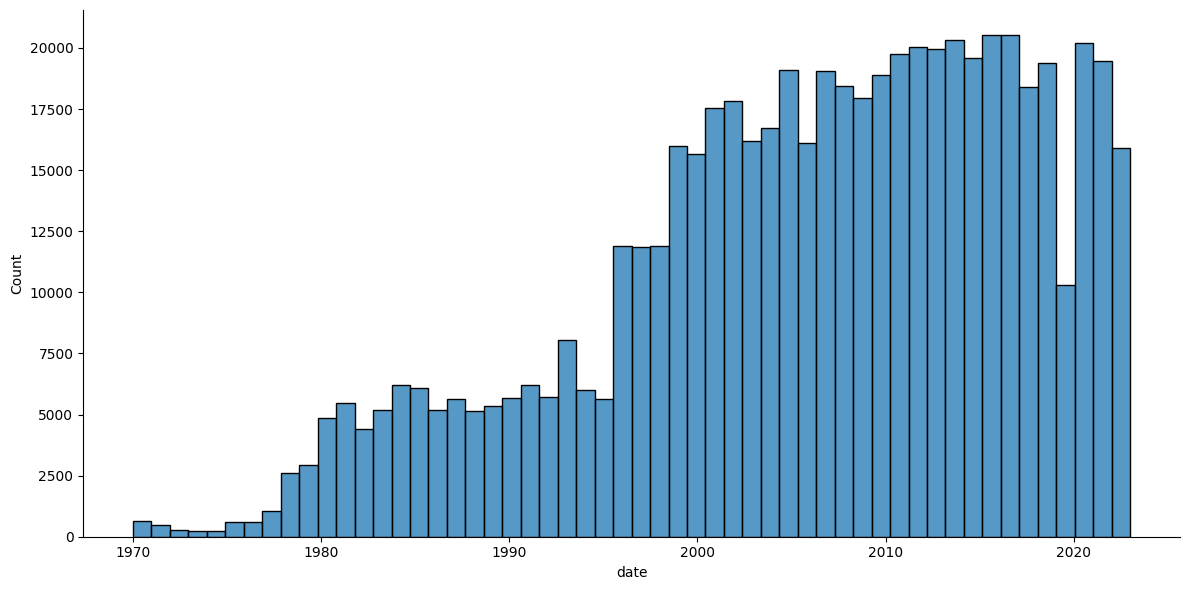

In [32]:
n_bins = math.ceil(math.log2(len(dataset)) + 1)
years = pd.to_datetime(dataset['date'], format='%Y-%m-%d').dt.year

sb.displot(join_df, 
                x=years, 
                kind="hist",
                row_order="desc",
                bins=len(years.unique()),
                height=6,
                aspect=2) #TODO: cambia nome dell'asse x

Analizzando la distribuzione degli anni a cui risalgono i contenuti dei vari record presenti nel dataset "races.csv" emerge come i dati più presenti siano quelli successivi agli anni 95 circa. Questo potrebbe essere dovuto al fatto che il ciclismo si sia affermato come sport (con un incremento notevole di importanza) solo in seguito a questa data (da controllare) o dal fatto che la sorgente di questi dati sia diventata un repository di informazioni rilevante soltanto a partire da quell'epoca.

Un'altra caratteristica rilevante riguarda la rappresentazione della classe di date adiacenti al 2020, anno in cui vediamo una netta assenza di informazioni rispetto agli anni circostanti. La spiegazione di questo fenomeno è plausibilmente da ritrovare nella pandemia di Covid-19 che in quel periodo storico ha limitato drasticamente la possibilità di avviare e partecipare a eventi pubblici e sportivi come le gare ciclistiche

In [33]:
tmp_df = pd.DataFrame({
    'race_name': join_df['race_name'],
    'cyclist_name': join_df['cyclist_name'],
    'year': years
})

tmp_df = tmp_df.drop_duplicates()

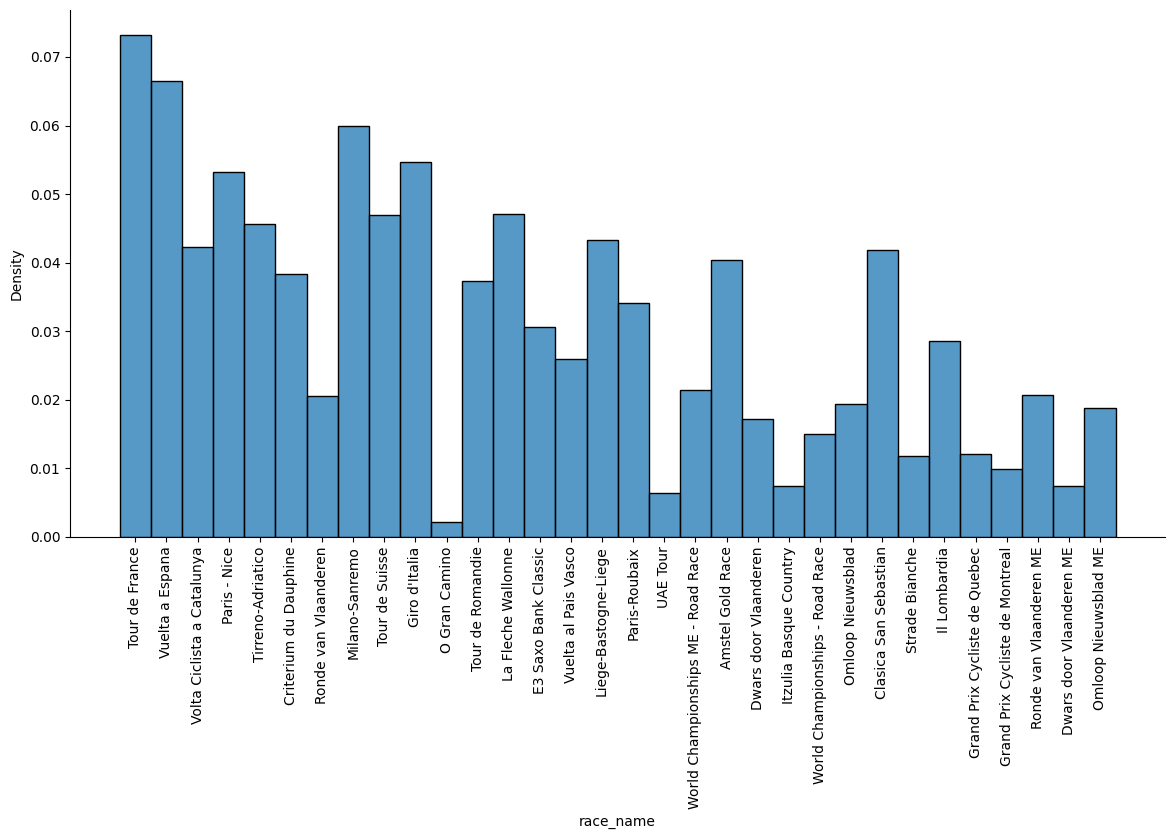

In [34]:
sb.displot(tmp_df, 
                x="race_name", 
                kind="hist",
                row_order="desc",
                bins=len(join_df['race_name'].unique()),
                stat='density',
                height=6,
                aspect=2) 
plt.xticks(rotation=90);

Nel grafico sopra analizziamo la "partecipazione alle gare" secondo i dati del nostro dataset. Per ottenere questo valore il grafico a barre riporta la frequenza in termini di record contenuti nel dataset per ogni differente competizione, assicurandoci di non contare la partecipazione di ogni ciclista ad ogni stage della stessa competizione nel calcolo della frequenza (ogni ciclista viene contato 1 sola volta per ogni coppia competizione-anno). Poiché i record non rappresentano corse quanto ciclisti all'interno di una corsa, questa valutazione ci permette di estrarre la suddetta informazione. 

Studiando questa distribuzione è possibile notare che alcune competizioni O Gran Camino, UAE Tour, Itzulia Basque Country e Dwars door Vlaanderen ME sono meno rappresentate nel nostro dataset in termini di partecipazione (partecipazione <= 1%). Nel caso di Dwars door Vlaanderen ME questo potrebbe essere dovuto all'aver tenuto una separazione tra la modalità "Men Elite" e la nomenclatura meno specifica sempre presente nel dataset. Questo discorso può essere esteso a tutte le altre competizioni segnalate come "ME"

Anni di nascista dell'ultimo secolo, valori nei range che ci possiamo aspettare.
I ciclisti con maggiore rappresentanza sono quelli nati prima del 2000 a partire dagli anni 60.

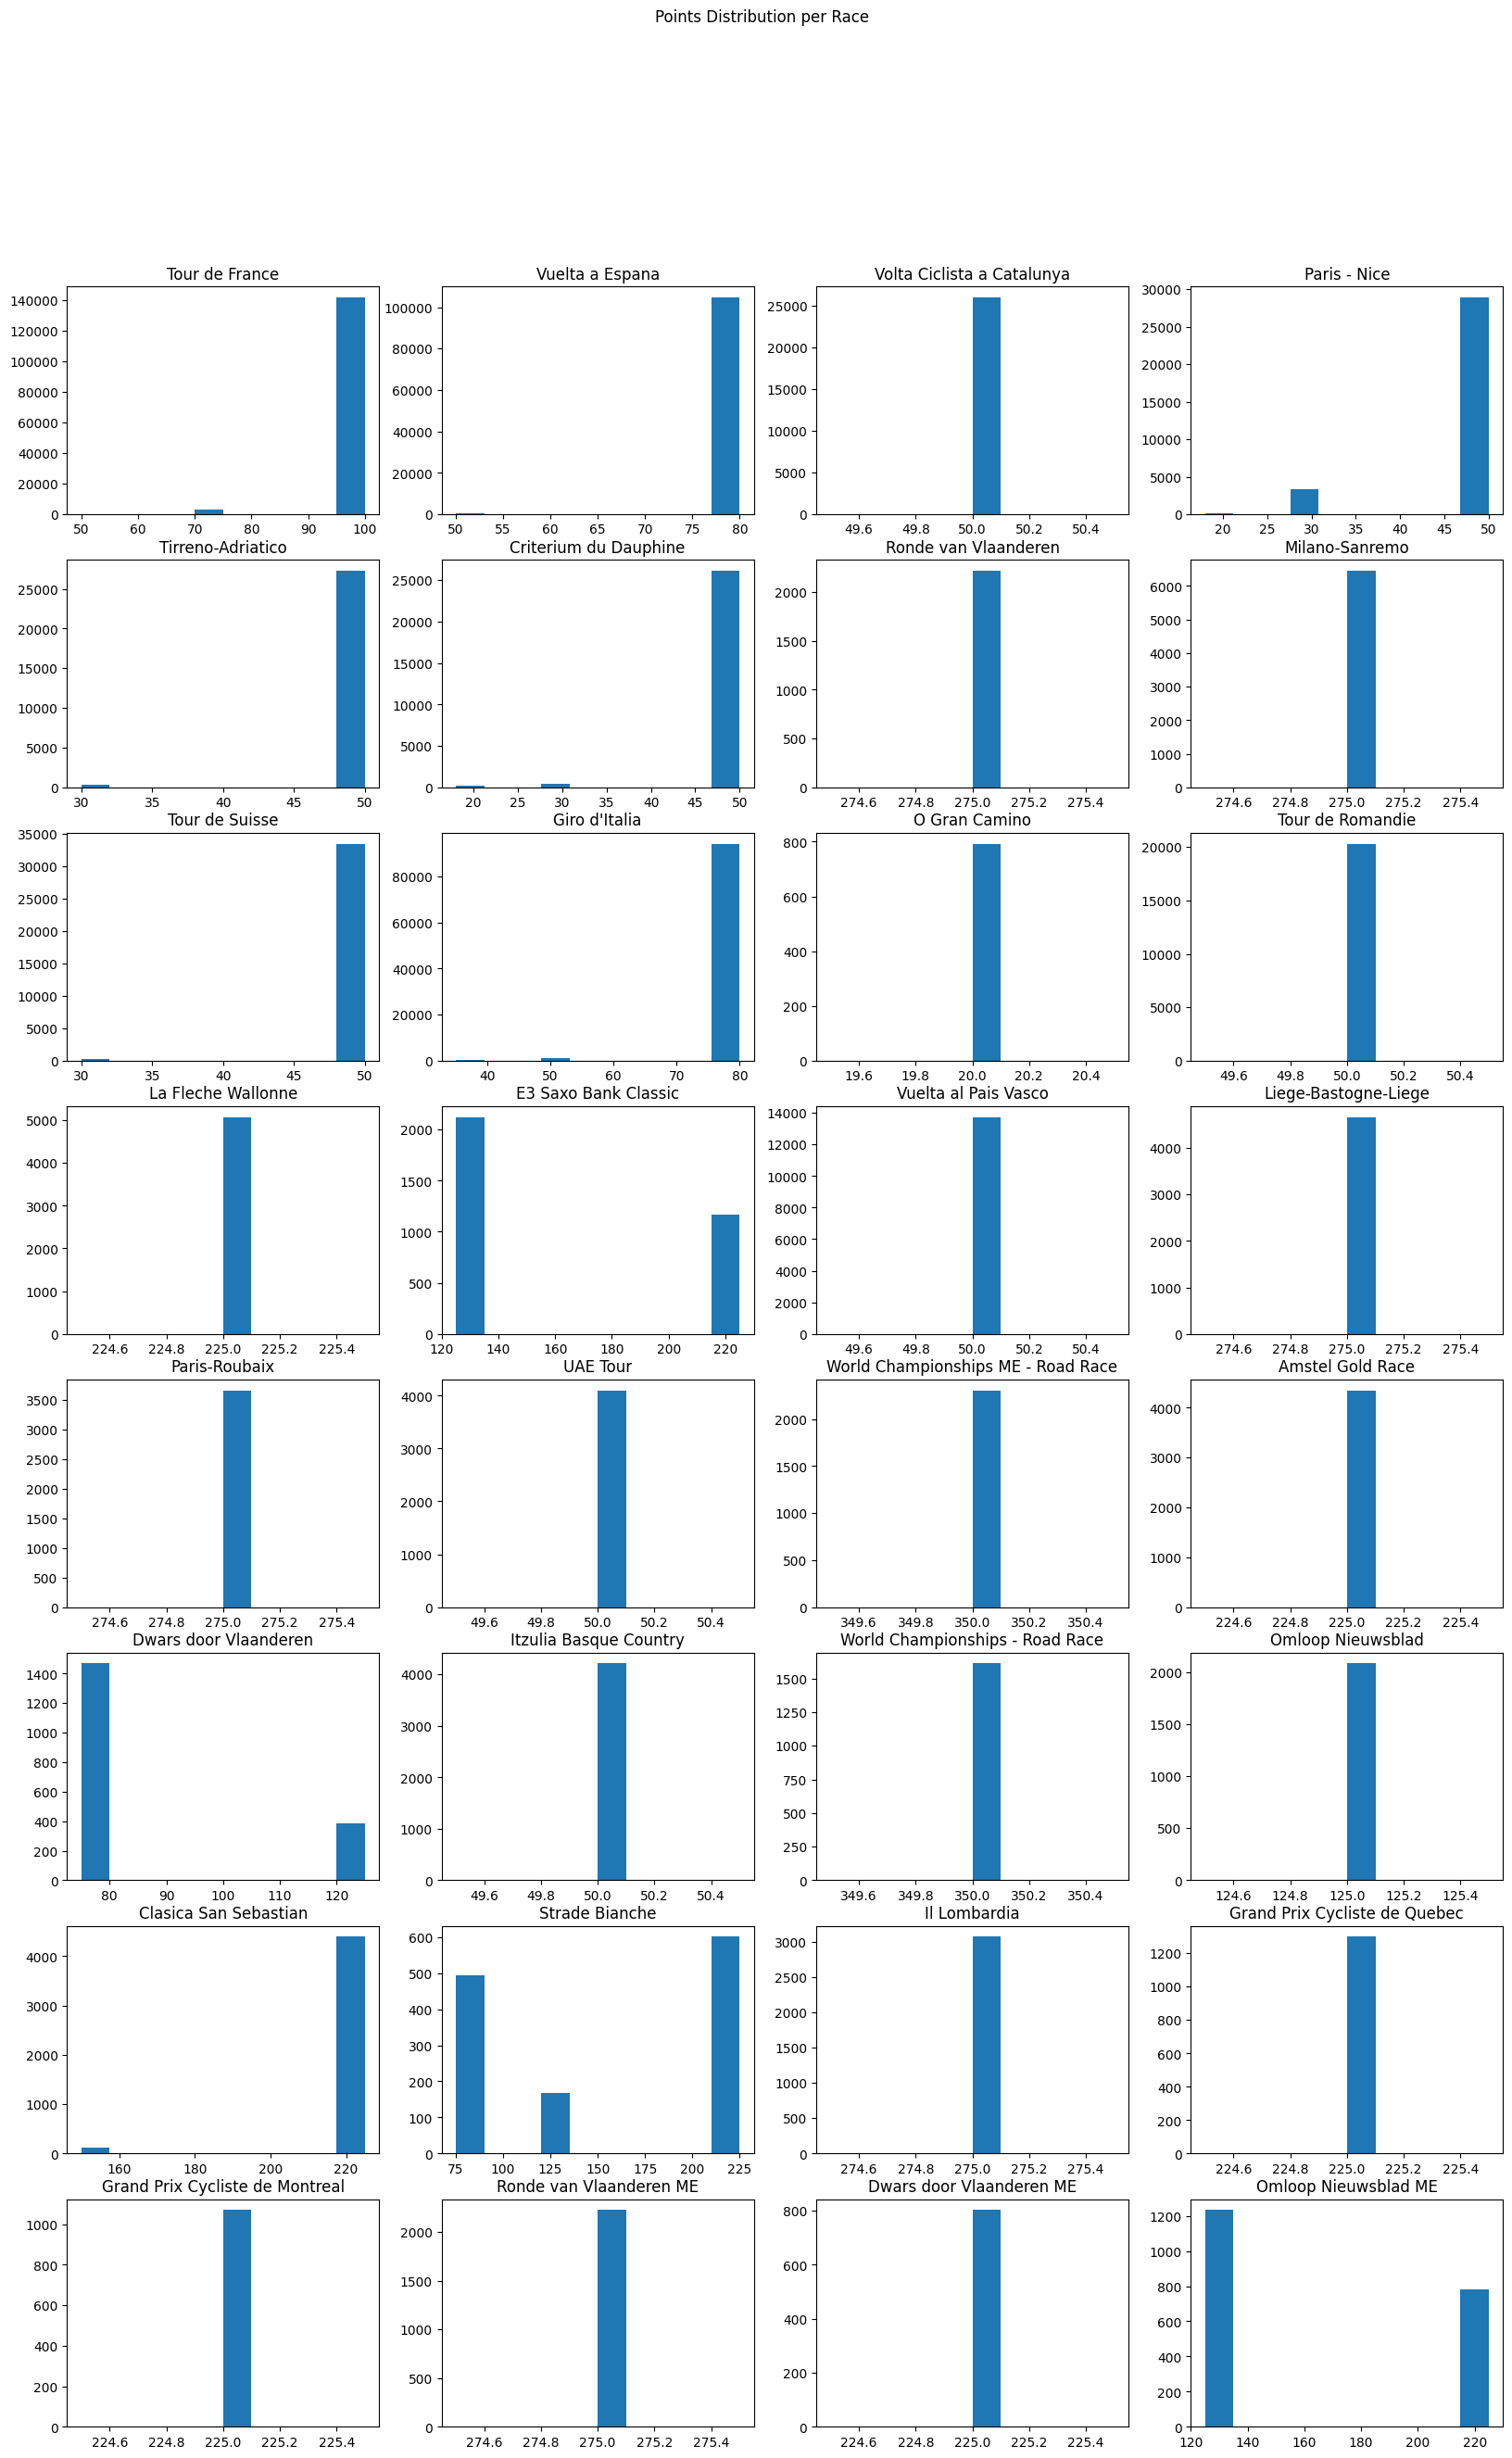

In [53]:
fig, ax = plt.subplots(8, 4, figsize=(20, 30))
fig.suptitle('Points Distribution per Race')
for i in range(0, 8):
    for j in range(0, 4):
        ax[i, j].hist(join_df[join_df['race_name'] == race_name[4*i+j]]['points'])
        ax[i, j].set_title(race_name[4*i+j])

Il nostro dataset presenta una maggioranza di dati per nazionalità europee. 

Motivazioni plausibili:
1. Il ciclismo è uno sport storicamente più rilevante in europa;
2. Le gare più importanti si tengono in europa:

    * Atleti più appasionati allo sport sono europei;
    * Gli atleti di nazioni distanti da quelle europee sono meno partecipi alle gare europee;
3. Il nostro dataset presenta dei bias sulle nazionalità dei ciclisti selezionati o sulle gare a cui questi hanno partecipato.

In [ ]:
sb.displot(dataset, 
                x="weight", 
                kind="hist",
                row_order="desc",
                bins=n_bins)

In [ ]:
plt.figure(figsize=(10, 5))
sb.boxplot(x='weight', data=dataset)
plt.show()

In [ ]:
sb.displot(dataset, 
                x="height", 
                kind="hist",
                row_order="desc",
                bins=n_bins)

In [ ]:
plt.figure(figsize=(10, 5))
sb.boxplot(x='height', data=dataset)
plt.show()

Secondo i dati da noi raccolti da fonti (citare) l'altezza media dei ciclisti dovrebbe essere tra i 175 e i 185 cm con un peso variabile tra i 60 e 70 Kg. I nostri grafici confermano questi dati con le classi maggioritarie per gli attributi localizzate in corrispodnenza di queste medie. Possiamo supporre che la sottorappresentazione dei valori superiori e inferiori non sia dovuta a bias del nostro dataset quanto alla naturale distribuzione statistica del ciclismo

Guardando i grafici precedenti è possibile ricercare la presenza di valori di default che nascondono mancanze nel dataset. Abbiamo rilevato che la distribuzione dei valori è simile a quella che ci potremmo attendere, se ci fosse stato un valore di default la sua frequenza sarebbe stata fuori scala. Da questo momento in poi considereremo questi attributi come privi di valori di default.

## Completeness Analysis
### Analisi dei NaN values

In [ ]:
dataset.isnull().sum()

In [ ]:
percent_missing = dataset.isnull().sum() * 100 / len(dataset) # compute the percentage of missing values
missing_value_df = pd.DataFrame({'column_name': dataset.columns,
                                 'percent_missing': percent_missing})

missing_value_df['percent_missing']

In [ ]:
missing_birthyear = dataset[dataset['birth_year'].isnull()]['_url'].to_list()
dataset[dataset['birth_year'].isnull()]

## Imputation

### Tentativo di imputazione manuale delle date di nascita mancanti sfruttando i dati del dataset 'races.csv'

I ciclisti nel dataset 'cyclist.csv' hanno età NaN in ogni record del dataset 'races.csv'

Abbiamo cercato di recuperare più dati possibile manualmente attraverso ricerce online supportate da confronti diretti con altri dati presenti nel dataset 'races.csv'

Una volta identificato un ciclista con alta probabilità abbiamo fatto una imputazione manuale del valore ottenuto nella feature 'birth_year' corrispondente

In [31]:
dataset.loc[dataset['_url'] == 'scott-davies', 'birth_year'] = 1995
dataset.loc[dataset['_url'] == 'vladimir-malakov', 'birth_year'] = 1958
dataset.loc[dataset['_url'] == 'antonio-zanini', 'birth_year'] = 1965
dataset.loc[dataset['_url'] == 'nevens-guy', 'birth_year'] = 1962
dataset.loc[dataset['_url'] == 'sergei-jermachenko', 'birth_year'] = 1956 

Ragionamento simile fatto anche per la nazionalità. L'unica mancante apparteneva al ciclista Scott Davies che era già stato correttamente identificato nella fase precedente, grazie a cui abbiamo rivenuto anche questa informazione

In [32]:
dataset.loc[dataset['_url'] == 'scott-davies', 'nationality'] = 'Great Britain'

In [33]:
#TODO usare info età corse per correggere alla perfezione
dataset['birth_year'] = dataset['birth_year'].fillna(dataset['birth_year'].mode()[0]) # substitue 8 remaining elements with mode

In [ ]:
dataset.isnull().sum() # check if missing values are filled correctly

### Imputation per altezza e peso

La nostra ipotesi di partenza è che altezza peso e nazionalità siano correlati. Desidereremmo sfruttare questa informazione per eseguire una imputazione di vicinanza nei record incompleti. 

Per poter procedere con questa strategia è essenziale stabilire le reali correlazioni tra questi attributi (confermando o smentendo quelle attese o scoprendone di nuove)

In [ ]:
dataset[dataset['height'].isnull() & dataset['weight'].isnull()]

In [ ]:
plt.figure(figsize=(30, 10))
sb.boxplot(x='nationality', y='height', data=dataset)
plt.xticks(rotation=90);
plt.show()

In [ ]:
plt.figure(figsize=(30, 10))
sb.boxplot(x='nationality', y='weight', data=dataset)
plt.xticks(rotation=90);
plt.show()

In [ ]:
plt.figure(figsize=(30, 10))
sb.scatterplot(x='height', y='weight', data=dataset, hue='nationality')
plt.show()

Dall'analisi qualitativa di questo boxplot emerge che distinguendo per nazionalità le distribuzioni probabilistiche degli attributi altezza e peso non siano particolarmente diversificate. Le poche differenze che possiamo notare (ad esempio Ecuador rispetto a Cina) non sono supportate da una sufficiente quantità di record (confronto tra 5 e 4 ciclisti).

Il tipo di imputazione che abbiamo ipotizzato in precedenza non sarebbe quindi sufficientemente efficace e potrebbe anzi produrre bias "peggiori" rispetto ad altri tipi di imputazione più semplce (come quella statistica). Procederemmo quindi sostituendo le altezze e i pesi mancanti con un'estrazione di valori casuali dalla distribuzione globale degli attributi

Obiettivo, sostituire i valori mantenendo la distribuzione

In [39]:
N = len(dataset[dataset['height'].notnull()])
bins = int(1 + 10/3 * math.log10(N))

dataset['height_discretized'] = pd.cut(dataset['height'], bins=bins, labels=[i for i in range(1, bins+1)])

In [ ]:
sb.displot(dataset, 
                x="height_discretized", 
                kind="hist",
                row_order="desc",
                bins=len(dataset['height_discretized'].unique()))

In [ ]:
dataset['height_discretized'].value_counts(normalize=True).sort_index()
# probabilità di ogni classe di altezza

In [42]:
probabilities = dataset['height_discretized'].value_counts(normalize=True).sort_index().to_list()
classes = [i for i in range(1, bins+1)] # the values to be extracted
random_height_discretized = random.choices(classes, weights=probabilities, k=len(dataset[dataset['height_discretized'].isnull()]))
nan_indices = dataset[dataset['height_discretized'].isna()]['height_discretized'].index

for idx, val in zip(nan_indices, random_height_discretized):
    dataset.at[idx, 'height_discretized'] = val

In [ ]:
dataset['height_discretized'].isnull().sum()

In [ ]:
sb.displot(dataset, 
                x="height_discretized", 
                kind="hist",
                row_order="desc",
                bins=len(dataset['height_discretized'].unique()))

Dopo aver sostituito i valori NaN dell'attributo "height_discretized" controlliamo che la distribuzione rimanga pressochè simile a quella originale

In [45]:
mean_heights = dataset[['height', 'height_discretized']].groupby(by='height_discretized', observed=True).mean()['height'] # compute the mean height for each heigt_discretized

def return_mean_height(row):
    return mean_heights[mean_heights.index == row['height_discretized']].iloc[0]

height_to_substitue = dataset[dataset['height'].isnull() & dataset['weight'].isnull()].apply(return_mean_height, axis=1)
dataset.loc[height_to_substitue.index, 'height'] = height_to_substitue.values

In [ ]:
sb.displot(dataset, 
                x="height", 
                kind="hist",
                row_order="desc",
                bins=n_bins)

solito controllo della distribuzione per verificare che sia pressoché simile a quella originale

In [47]:
imputer = KNNImputer(n_neighbors=6) #TODO: controllare bene se vada bene questo valore di n_neighbors

imputed_values = imputer.fit_transform(dataset[['height', 'weight']])
dataset[['height', 'weight']] = imputed_values

In [ ]:
sb.displot(dataset, 
                x="weight", 
                kind="hist",
                row_order="desc",
                bins=n_bins)

per sostituire i valori NaN della feature "weight" abbiamo usato il KNNImputer, utilizzando un numero di vicini che permettesse di mantenere la distribuzione originale